In [1]:
import colorsys
from datetime import date, datetime, timedelta
import io
import re

import matplotlib.pyplot as plt
from matplotlib import lines as mlines
from matplotlib import gridspec
from matplotlib import dates as mdates
from matplotlib import ticker as mticker
import pandas as pd
import requests
import numpy as np
from scipy import stats

import wrap_technote as tn
import ausweather

In [2]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "Segoe UI"
plt.rcParams["font.size"] = 10

In [3]:
report = tn.Report("Barossa", "2019-20")

In [4]:
report.read_table("Report_rainfall_stations")

,report,previous_users,bom_station_no,bom_station_name,data_start,mean_period_start,mean_period_finish,rf_period_start,rf_period_finish,filename
3,Barossa,SW & GW,23300,Angaston,1950-01-01,1977-07-01,2019-06-30,2018-07-01,2019-09-30,Report_Rainfall_stations.xlsx
4,Barossa,SW & GW,23318,Tanunda,1950-01-01,1977-07-01,2019-06-30,2018-07-01,2019-09-30,Report_Rainfall_stations.xlsx
5,Barossa,SW,23752,Williamstown,1950-01-01,1977-07-01,2019-06-30,2018-07-01,2019-09-30,Report_Rainfall_stations.xlsx


In [5]:
station = 23318

In [6]:
rdfn = report.rainfall_dfn(station)

In [14]:
rdfn

report                                      Barossa
previous_users                              SW & GW
bom_station_no                                23318
bom_station_name                            Tanunda
data_start                      1950-01-01 00:00:00
mean_period_start               1977-07-01 00:00:00
mean_period_finish              2019-06-30 00:00:00
rf_period_start                 2018-07-01 00:00:00
rf_period_finish                2019-09-30 00:00:00
filename              Report_Rainfall_stations.xlsx
Name: 4, dtype: object

In [7]:
fn = [f for f in report.rainfall_path.glob(f"report_rainfall_*_{station}*.xlsx")][0]
d = pd.read_excel(fn, sheet_name=None)
d.keys()

odict_keys(['water-use year', 'trend line', 'monthly means', '2018-19 monthly totals'])

In [8]:
mm = d["monthly means"].set_index("Date")
pm = d["2018-19 monthly totals"]  # .set_index(['Date', 'Date.1'])
pm["Date"] = pm.Date.fillna(method="ffill")
pm = pm.set_index(["Date", "Date.1"])

In [9]:
mm

,Rain
Date,
7,71.464286
8,68.347619
9,65.480952
10,41.952381
11,33.126190
12,30.495238
1,19.402381
2,18.804762
3,27.221429


In [10]:
pm

Rain
Date   Date.1      
2018.0 7       32.4
       8       79.5
       9       28.3
       10      28.0
       11      39.4
       12      16.1
2019.0 1        0.2
       2        7.6
       3        5.0
       4        0.6
       5       64.0
       6       58.9
       7       58.5
       8       60.6
       9       45.1

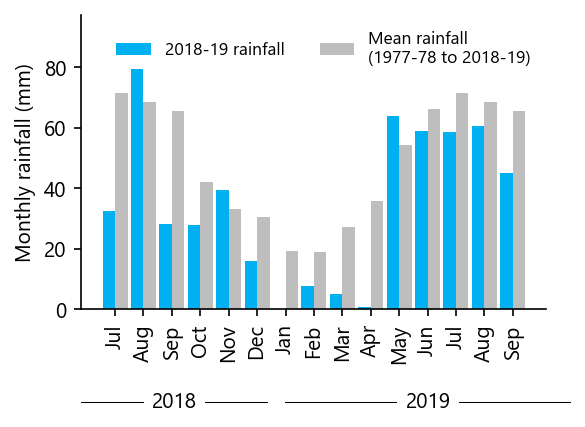

In [15]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax = tn.plot_rainfall_monthly_means(
    mm.Rain,
    pm.Rain,
    "1977-78 to 2018-19",
    "2018-19",
    "2018",
    "2019",
    ax=ax,
    xtl_kws=dict(fontsize="medium", rotation=90, ha="center"),
    bar_width=0.44,
)
fig.savefig(f"monthly_rainfall_{station}_{rdfn.name}.png")

In [3]:
colour = {
    "rainfall": (0 / 255, 176 / 255, 240 / 255, 1),
    "mean": "#bebebe",
}

In [4]:
data = ausweather.fetch_bom_station_from_silo(
    23318, "kent.inverarity@sa.gov.au", "1950-01-01"
)
df = data["df"]
rf_annual = data["annual"]
rf_annual_srn = data["srn"]

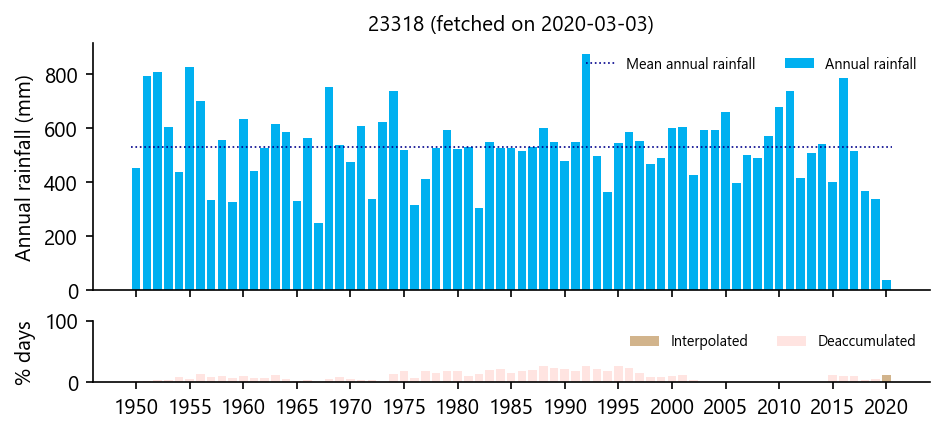

In [7]:
ausweather.plot_silo_station(
    rf_annual,
    rf_annual.mean(),
    rf_annual_srn,
    title=f"23318 (fetched on {date.today()})",
)

# Prepare data

In [8]:
mean_period_start = pd.Timestamp("1977-07-01")
mean_period_finish = pd.Timestamp("2019-06-30")

rf_period_start = pd.Timestamp("2018-07-01")
rf_period_finish = pd.Timestamp("2019-09-30")

# Configure charting parameters

In [20]:
rgba_to_hsva = lambda c: tuple(list(colorsys.rgb_to_hsv(c[0], c[1], c[2])) + [c[3]])

colour = {
    "rainfall": (0 / 255, 176 / 255, 240 / 255, 1),
    "mean": "#bebebe",
}


def darken(rgba, factor):
    h, s, v = colorsys.rgb_to_hsv(rgba[0], rgba[1], rgba[2])
    r, g, b = colorsys.hsv_to_rgb(h, s, v * factor)
    return (r, g, b, rgba[3])

# Annual rainfall with trend line

Calculate annual rainfall, and the linear trend line.

In [21]:
rf_mm_subset = df[(df.Date >= mean_period_start) & (df.Date <= mean_period_finish)]
rf_mm_subset.loc[:, "wu_year"] = [tn.date_to_wateruseyear(d) for d in rf_mm_subset.Date]
rf_wuy = rf_mm_subset.groupby("wu_year").Rain.sum()
rf_wuy_x = np.arange(len(rf_wuy))
slope, intercept, r_value, p_value, std_err = stats.linregress(rf_wuy_x, rf_wuy.values)
print(f"Annual change in total rainfall: {slope:+.2f} mm/y")

Annual change in total rainfall: +0.48 mm/y


Total water-use (financial) year annual rainfall, for the last 15 years

In [15]:
rf_wuy.tail(15)

wu_year
2004-05    577.8
2005-06    712.6
2006-07    437.8
2007-08    374.5
2008-09    528.9
2009-10    544.3
2010-11    862.4
2011-12    597.0
2012-13    404.7
2013-14    634.3
2014-15    385.8
2015-16    526.5
2016-17    650.1
2017-18    474.8
2018-19    360.0
Name: Rain, dtype: float64

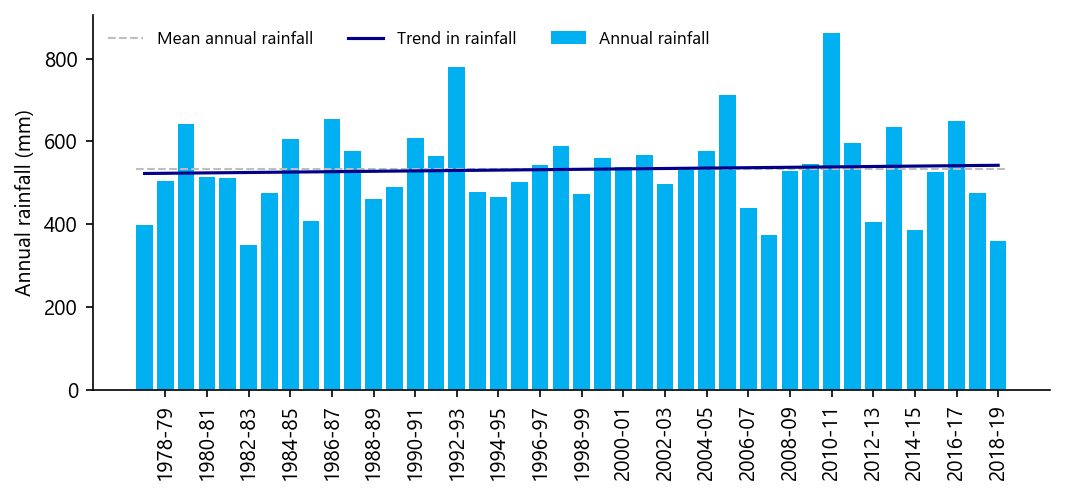

In [11]:
width = 0.8
fig = plt.figure(figsize=(7.2, 3.4))
ax = fig.add_subplot(111)

ax.bar(
    rf_wuy_x,
    rf_wuy.values,
    width=width,
    facecolor=colour["rainfall"],
    label="Annual rainfall",
)
ax.plot(
    [rf_wuy_x[0] - width / 2, rf_wuy_x[-1] + width / 2],
    [rf_wuy.mean(), rf_wuy.mean()],
    color=colour["mean"],
    ls="--",
    lw=1,
    label="Mean annual rainfall",
)
trend_x = np.asarray([rf_wuy_x[0], rf_wuy_x[-1]])
trend_y = [slope * tx + intercept for tx in trend_x]
ax.plot(trend_x, trend_y, color="darkblue", label="Trend in rainfall")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ticks_per_label = 2
xticks = np.arange(0, len(rf_wuy_x), ticks_per_label)
while xticks[-1] != rf_wuy_x[-1]:
    xticks += 1
ax.set_xticks(xticks)

_ = ax.set_xticklabels(
    rf_wuy.index[xticks], rotation=90, ha="center", fontsize="medium"
)
ax.set_ylabel("Annual rainfall (mm)", fontsize="medium")
ax.legend(loc="best", fontsize="small", frameon=False, ncol=3)
# ax.set_ylim(0, 950)
fig.tight_layout()
fig.savefig("annual_rainfall.png", dpi=150)

# Total monthly rainfall for the last 18 months, with monthly means

Mean monthly rainfall:

In [12]:
period_label = (
    tn.date_to_wateruseyear(mean_period_start)
    + " to "
    + tn.date_to_wateruseyear(mean_period_finish)
)
print(f"Period which has been averaged: {period_label}")

rf_mm_subset = df[(df.Date >= mean_period_start) & (df.Date <= mean_period_finish)]
rf_mm = (
    rf_mm_subset.groupby([rf_mm_subset.Date.dt.year, rf_mm_subset.Date.dt.month])
    .Rain.sum()
    .mean(level=1)
)
rf_mm

Period which has been averaged: 1977-78 to 2018-19


Date
7     71.464286
8     68.347619
9     65.480952
10    41.952381
11    33.126190
12    30.495238
1     19.402381
2     18.804762
3     27.221429
4     35.614286
5     54.238095
6     66.109524
Name: Rain, dtype: float64

Monthly rainfall totals, over the last 18 months:

In [13]:
rf_period = df[(df.Date >= rf_period_start) & (df.Date <= rf_period_finish)]
rf_period_m = rf_period.groupby([df.Date.dt.year, df.Date.dt.month]).Rain.sum()
rf_period_m

Date  Date
2018  7       32.4
      8       79.5
      9       28.3
      10      28.0
      11      39.4
      12      16.1
2019  1        0.2
      2        7.6
      3        5.0
      4        0.6
      5       64.0
      6       58.9
      7       58.5
      8       60.6
      9       45.1
Name: Rain, dtype: float64

Make a chart.

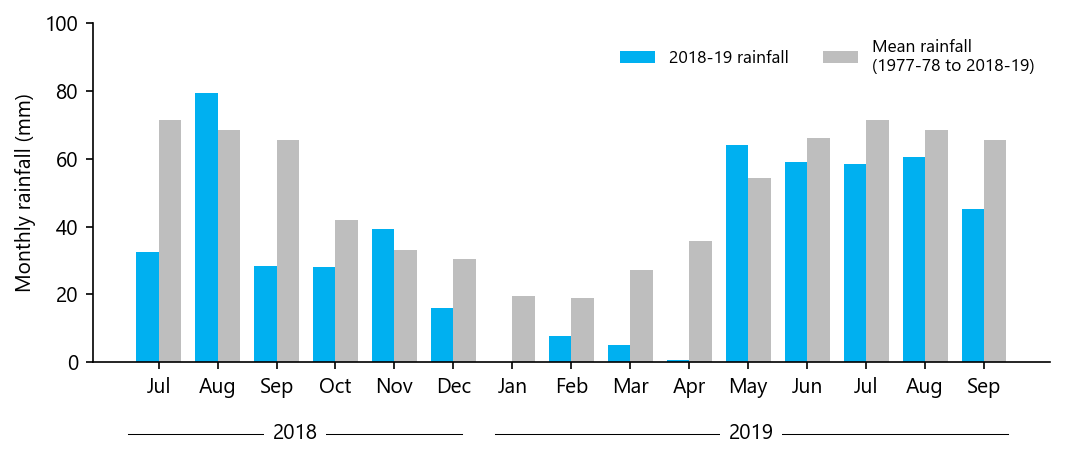

In [14]:
width = 0.38
month_numbers = rf_period_m.index.get_level_values(1)
month_names = [date(2000, mn, 1).strftime("%b") for mn in month_numbers]
rf_period_mm = [rf_mm.loc[mn] for mn in month_numbers]

fig = plt.figure(figsize=(7.2, 3.0))
# fig = plt.figure(figsize=(8, 2.8))
ax = fig.add_subplot(111)
rf_period_x = np.arange(len(month_numbers)) - width / 2
rf_period_mm_x = np.arange(len(month_numbers)) + width / 2
ax.bar(
    rf_period_x,
    rf_period_m.values,
    width=width,
    facecolor=colour["rainfall"],
    label="2018-19 rainfall",
)
ax.bar(
    rf_period_mm_x,
    rf_period_mm,
    width=width,
    facecolor=colour["mean"],
    label=f"Mean rainfall\n({period_label})",
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(range(len(month_numbers)))
_ = ax.set_xticklabels(month_names, rotation=0, ha="center", fontsize="medium")
ax.set_ylabel("Monthly rainfall (mm)", fontsize="medium")
ax.legend(loc="upper right", fontsize="small", frameon=False, ncol=2)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + 0.1, pos.width, pos.height - 0.1])
ax.set_ylim(0, 100)
ly = 0.02
l1_x = (pos.x0, pos.x0 + 0.31)
l2_x = [pos.x0 + 0.34, pos.x0 + pos.width + 0.04]
ax.text(
    l1_x[0] + (l1_x[1] - l1_x[0]) / 2,
    ly,
    "2018",
    transform=fig.transFigure,
    fontsize="medium",
    va="center",
    ha="center",
    bbox=dict(facecolor="white", edgecolor="none"),
)
ax.text(
    l2_x[0] + (l2_x[1] - l2_x[0]) / 2,
    ly,
    "2019",
    transform=fig.transFigure,
    fontsize="medium",
    va="center",
    ha="center",
    bbox=dict(facecolor="white", edgecolor="none"),
)

line1 = mlines.Line2D(l1_x, [ly, ly], color="k", lw=0.5, transform=fig.transFigure)
line2 = mlines.Line2D(l2_x, [ly, ly], color="k", lw=0.5, transform=fig.transFigure)
for line in (line1, line2):
    line.set_clip_on(False)
    ax.add_line(line)
fig.tight_layout()
fig.savefig("monthly_rainfall.png", dpi=150)